In [2]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import sys
BASE_PATH = os.path.realpath('..')
DATASETS_DIR = os.path.join(BASE_PATH, 'datasets')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR[:-3] not in sys.path:
    sys.path.append(LIB_DIR[:-3])

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from importlib import reload

In [3]:
RESULTS_DIR = os.path.join(BASE_PATH, 'results')

In [4]:
from lib import fca_interp as fcai

In [5]:
from lib.utils_ import powerset

In [6]:
from importlib import reload

In [7]:
from sklearn.datasets import load_boston

# Create the model
Following https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

# Настройка Pattern Structures

In [8]:
from keras.datasets import mnist

Using TensorFlow backend.


In [9]:
img_rows, img_cols = 28, 28

In [10]:
preds_test = np.load('mnist_test_preds.numpy', allow_pickle=True)

In [11]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [12]:
len(x_test), len(x_train)

(10000, 60000)

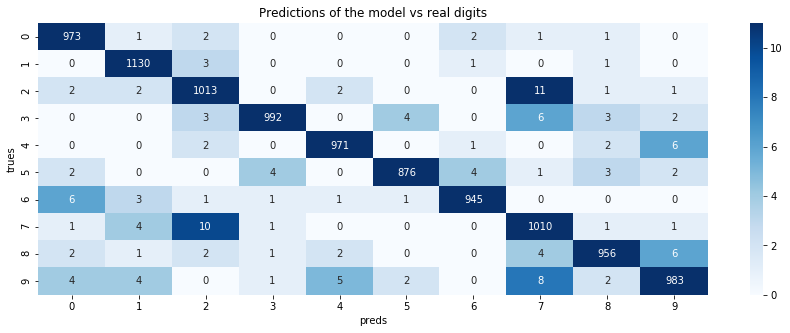

In [13]:
cds = pd.DataFrame()
cds['trues'] = y_test
cds['preds'] = preds_test
cds['cnt'] = 1
cds = cds.astype(int)
cds.head()

plt.figure(figsize=(15,5))
cds = cds.pivot_table(index='trues',columns='preds', aggfunc='sum', values='cnt').fillna(0).astype(int)
sns.heatmap(cds, annot=True, cmap='Blues', fmt='d', vmax=(cds-np.diag(cds)*np.eye(len(cds))).max().max())
plt.title('Predictions of the model vs real digits')
plt.show()

In [14]:
(cds-np.diag(cds)*np.eye(len(cds))).sum().sort_values(ascending=False)

preds
7    31.0
2    23.0
9    18.0
0    17.0
1    15.0
8    14.0
4    10.0
6     8.0
3     8.0
5     7.0
dtype: float64

In [15]:
x_test_flatten = x_test.reshape((x_test.shape[0], img_rows*img_cols))

In [36]:
x_test_flatten = x_test_flatten[:1000]
y_test = y_test[:1000]
preds_test = preds_test[:1000]

In [29]:
ds = pd.DataFrame(x_test_flatten)
ds = ds.astype(int)
print(ds.shape)
ds.columns = [f"({y},{x})" for y in range(img_rows) for x in range(img_cols)]
ds.index = ds.index.astype(str)
ds.head()

(1000, 784)


,"(0,0)","(0,1)","(0,2)","(0,3)","(0,4)","(0,5)","(0,6)","(0,7)","(0,8)","(0,9)",...,"(27,18)","(27,19)","(27,20)","(27,21)","(27,22)","(27,23)","(27,24)","(27,25)","(27,26)","(27,27)"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
mvcntx_full = fcai.MultiValuedContext(ds, cat_attrs=[],)

In [31]:
mvcntx_dict = {}

In [32]:
def compare_concept_image(int_, mvcntx, mvcntx_full, ds):
    ext_ = mvcntx.get_extent(int_)
    ext_full = mvcntx_full.get_extent(int_)
    strongness = len(ext_)/len(ext_full) if len(ext_)>0 else 0
    
    plt.subplot(121)
    plt.imshow(np.array([np.mean(v) for k,v in int_.items()]).reshape((img_rows, img_cols)), cmap='Greys')
    plt.title('Image created from intent')

    plt.subplot(122)
    plt.imshow(ds.loc[ext_full].mean(0).values.reshape((28,28)), cmap='Greys')
    plt.title('Mean image of extent')


    plt.subplots_adjust(top=0.99)
    plt.suptitle(f'Strongness: {len(ext_)/len(ext_full) if len(ext_)>0 else 0}')
    plt.tight_layout()

    plt.show()    

## Check speed of the PC

In [37]:
from datetime import datetime

In [38]:
n_objs = [3,5,7,8,9,10,12]
n_concepts = []
dts = []

for n_obj in tqdm(n_objs):
    mvcntx = fcai.MultiValuedContext(ds.head(n_obj), cat_attrs=[])
    fm = fcai.FormalManager(mvcntx)
    
    t1 = datetime.now()
    fm.construct_concepts(use_tqdm=False)
    t2 = datetime.now()
    
    n_concepts.append(len(fm.get_concepts()))
    dts.append((t2-t1).total_seconds())

KeyboardInterrupt: 

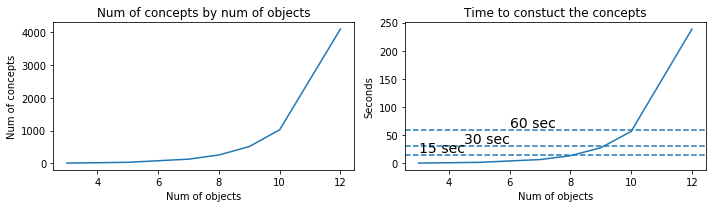

In [29]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(n_objs, n_concepts)
plt.title('Num of concepts by num of objects')
plt.ylabel('Num of concepts')
plt.xlabel('Num of objects')

plt.subplot(1,2,2)
plt.plot(n_objs, dts)
plt.title('Time to constuct the concepts')
plt.ylabel('Seconds')
plt.xlabel('Num of objects')
for idx, y in enumerate([15,30,60]):
    plt.axhline(y, linestyle='--')
    plt.text(3+1.5*idx, y+5, f"{y} sec", size=14)
plt.tight_layout()
plt.show()

In [25]:
def get_curtime_str():
    from datetime import datetime
    return datetime.now().strftime('%d.%m.%y_%H:%M')

# Going through each digit

## Digit 0

## All digits in cycle

In [39]:
%%time
for cur_digit in tqdm(set(preds_test)):
    flg = preds_test==cur_digit
    mvcntx = fcai.MultiValuedContext(ds[flg], cat_attrs=[])
    fm = fcai.FormalManager(mvcntx, context_full=mvcntx_full)
    fm.construct_concepts(algo='FromMaxConcepts_Bootstrap', n_bootstrap_epochs='2times',
                      sample_size_bootstrap=5, n_best_bootstrap_concepts=15)
    fm.save_concepts_json(RESULTS_DIR+f'/mnist__digit{cur_digit}_{get_curtime_str()}.json')





CPU times: user 56min 7s, sys: 27.6 s, total: 56min 34s
Wall time: 55min 50s


In [43]:
RESULTS_DIR+f'/mnist__digit{cur_digit}_{get_curtime_str()}.json'

'/opt/results/mnist__digit9_08.06.20_10:55.json'

In [42]:
get_curtime_str()

'08.06.20_10:54'

# Calc feature importances

In [933]:
fimps = {}

In [968]:
c = fm.get_concept_by_id(10)
un_idx = list(c._up_neighbs)[0]
un = fm.get_concept_by_id(un_idx)

In [971]:
int_ = c.get_intent()
int_un = un.get_intent()

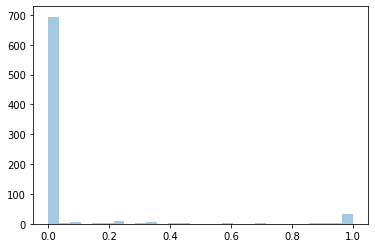

In [1020]:
sns.distplot(x, kde=False)

In [974]:
pd.Series(int_)-pd.Series(int_un)

TypeError: unsupported operand type(s) for -: 'tuple' and 'tuple'

In [970]:
un

PatternStructure 3
level: 2
extent (len: 934): 0, 17, 34, 36, 41, 60, 64, 70, 75, 79, 80, 83, 86, 97, 111, 114, 122, 124, 141, 171, 175, 220, 223, 229, 234, 243, 254, 255, 263, 282, 301, 307, 321, 328, 337, 358, 370, 383, 410, 411, 413, 415, 438, 494, 510, 550, 554, 557, 579, 585, 605, 626, 636, 649, 651, 666, 667, 676, 679, 689, 702, 703, 705, 726, 746, 756, 810, 825, 832, 841, 842, 844, 846, 852, 859, 880, 898, 911, 917, 924, 930, 941, 946, 950, 960, 987, 1006, 1012, 1055, 1062, 1071, 1096, 1100, 1104, 1110, 1117, 1119, 1122, 1126, 1133, 1141, 1143, 1156, 1164, 1171, 1173, 1175, 1186, 1206, 1216, 1241, 1244, 1276, 1283, 1299, 1321, 1346, 1347, 1355, 1359, 1361, 1363, 1366, 1369, 1386, 1401, 1414, 1494, 1496, 1497, 1498, 1505, 1507, 1522, 1540, 1543, 1544, 1563, 1564, 1566, 1576, 1581, 1595, 1606, 1624, 1660, 1681, 1699, 1703, 1705, 1710, 1716, 1718, 1721, 1741, 1750, 1770, 1776, 1783, 1784, 1792, 1799, 1805, 1806, 1809, 1814, 1848, 1875, 1887, 1903, 1919, 1925, 1933, 1935, 1949, 1950

In [1078]:
fimps = {}
for c in tqdm(fm_stab.get_concepts()):
    if len(c.get_extent())==0:
        continue
    for un_idx in c._up_neighbs:
        un = fm_stab.get_concept_by_id(un_idx)
        new_int = c._new_attrs
        
        
        int_ = c.get_intent()
        int_un = un.get_intent()
        #feat_weight = 1 - pd.Series({k:v if type(v)!=tuple else v[1]-v[0] for k,v in int_.items()})/ pd.Series({k:v if type(v)!=tuple else v[1]-v[0] for k,v in int_un.items()})
        feat_weight = pd.Series({k:v if type(v)!=tuple else v[1]-v[0] for k,v in int_un.items()})-pd.Series({k:v if type(v)!=tuple else v[1]-v[0] for k,v in int_.items()})
        feat_weight = feat_weight.fillna(0)
        
        ext_ = mvcntx_full.get_extent(int_)
        ext_un = mvcntx_full.get_extent(int_un)
        preds_ = np.mean(preds_test[ds.index.isin(ext_)])
        preds_un = np.mean(preds_test[ds.index.isin(ext_un)])
        
        if new_int is None:
            print(c.get_id())
            continue
        
        new_feats = new_int
        strongness_diff = c._metrics['strongness'] - un._metrics['strongness']
        mean_pred_diff = preds_-preds_un
        for f in new_feats:
            #fimps[f] = fimps.get(f,[])+[strongness_diff*feat_weight[f]]
            fimps[f] = fimps.get(f,[])+[mean_pred_diff*feat_weight[f]]
#fimps

In [1079]:
for f in ds.columns:
    if f not in fimps:
        #print(f)
        fimps[f] = [0]

In [1080]:
fimps_mean = pd.Series({k:np.mean(np.abs(v)) for k,v in fimps.items()}).sort_values(ascending=False)
fimps_median = pd.Series({k:np.median(np.abs(v)) for k,v in fimps.items()}).sort_values(ascending=False)
fimps_sum = pd.Series({k:np.sum(np.abs(v)) for k,v in fimps.items()}).sort_values(ascending=False)

fimps_mean /= fimps_mean.sum()
fimps_median /= fimps_median.sum()
fimps_sum /= fimps_sum.sum()

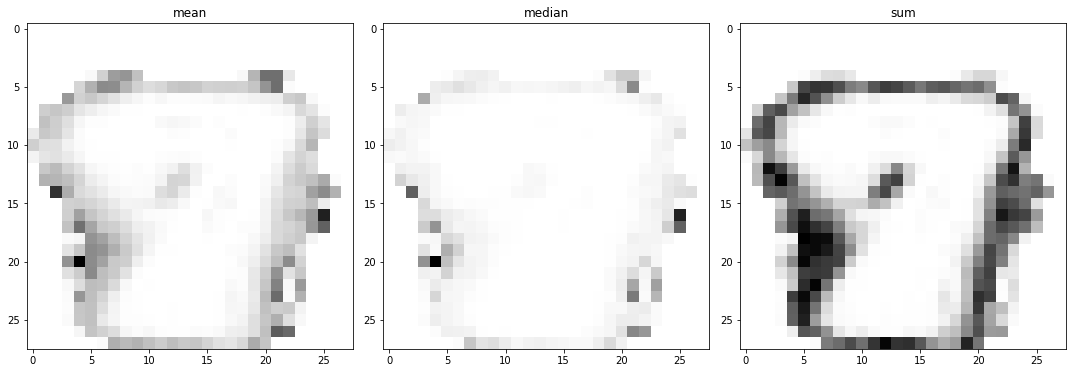

In [1082]:
plt.figure(figsize=(15,5))
for idx, s in enumerate([fimps_mean, fimps_median, fimps_sum]):
    plt.subplot(1,3,idx+1)
    plt.title(['mean','median','sum'][idx])
    plt.imshow(np.array([s[f] for f in ds.columns]).reshape((img_rows, img_cols)), cmap='Greys')
plt.tight_layout()
plt.show()

In [1055]:
def get_intent_image(int_, cols_order):
    return pd.Series({k:np.mean(v) for k,v in int_.items()})[cols_order].values.reshape((28,28))

In [957]:
fm.get_concept_by_id(50)

PatternStructure 50
level: 5
extent (len: 124): 86, 223, 229, 254, 321, 438, 626, 702, 703, 756, 941, 1244, 1361, 1386, 1624, 1681, 1784, 2024, 2141, 2238, 2252, 2262, 2275, 2301, 2507, 2565, 2567, 2591, 2837, 2887, 2968, 3040, 3054, 3079, 3125, 3309, 3511, 3609, 3743, 3993, 4049, 4064, 4089, 4130, 4453, 4624, 4697, 4767, 4781, 4815, 4865, 4970, 4991, 5064, 5071, 5077, 5180, 5234, 5277, 5317, 5324, 5326, 5334, 5372, 5402, 5466, 5485, 5540, 5576, 5795, 5798, 5999, 6158, 6263, 6292, 6561, 6586, 6589, 6837, 6853, 6960, 7021, 7059, 7124, 7141, 7144, 7145, 7276, 7334, 7362, 7390, 7493, 7648, 7677, 7744, 7766, 7960, 8106, 8124, 8134, 8151, 8188, 8234, 8248, 8364, 8398, 8608, 8688, 8727, 8749, 8791, 8815, 8837, 8871, 8874, 9077, 9413, 9543, 9806, 9816, 9823, 9837, 9868, 9963
intent (len: 784): (0,0) = 0, (0,1) = 0, (0,2) = 0, (0,3) = 0, (0,4) = 0, (0,5) = 0, (0,6) = 0, (0,7) = 0, (0,8) = 0, (0,9) = 0, (0,10) = 0, (0,11) = 0, (0,12) = 0, (0,13) = 0, (0,14) = 0, (0,15) = 0, (0,16) = 0, (0,17) =

# Интерпретируем минимальные понятия

In [853]:
sc = select_smallest_covering_hyps([c for c in fm_stab.get_concepts() if c._metrics['strongness']>=0.75], use_pruning=True)
len(sc), len(calc_cover_of_concepts(sc)), len(calc_cover_of_concepts(sc))/flg.sum()

(27, 1004, 0.9644572526416907)

In [854]:
for c1 in sc:
    for c2 in sc:
        assert c1==c2 or (not c1.is_subconcept_of(c2) and not c2.is_subconcept_of(c1)), f'Concepts {c1._idx} and {c2._idx} are connected'

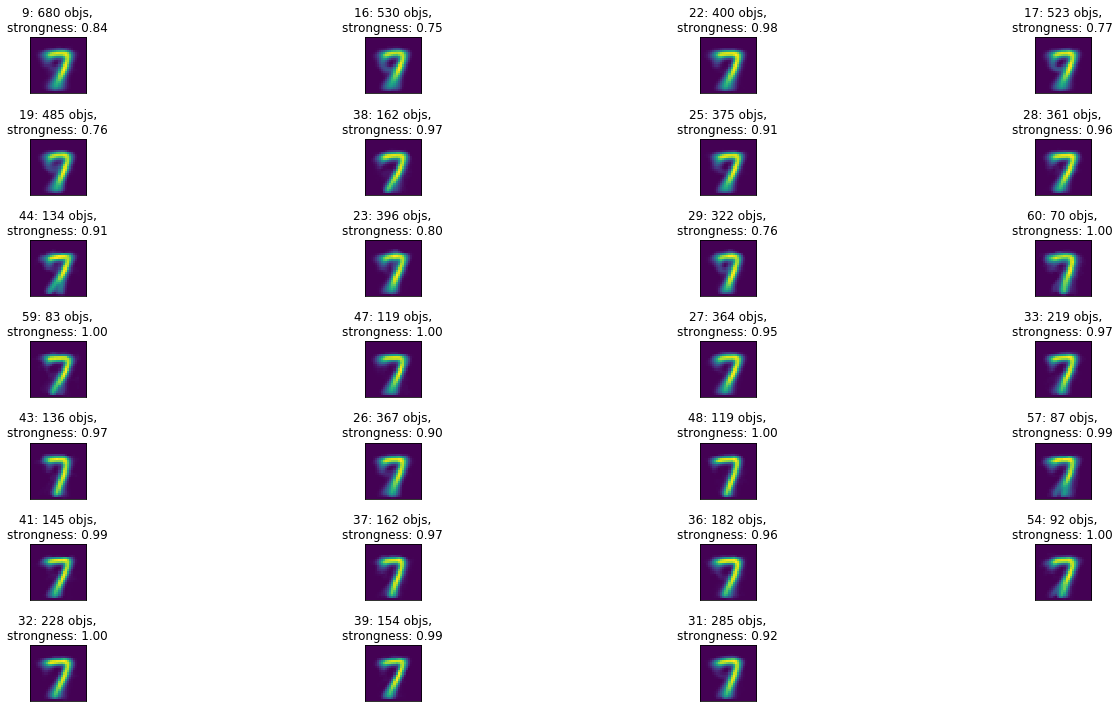

In [859]:
plt.figure(figsize=(20,10))
for idx, c in enumerate(sc):
    plt.subplot(7,4,idx+1)
    str_ = f"{c.get_id()}: {len(c.get_extent())} objs,\nstrongness: {c._metrics['strongness']:.2f}"
    ext_full = mvcntx_full.get_extent(c.get_intent())
    img = ds.loc[ext_full].mean(0).values.reshape((img_rows, img_cols))
    #plt.pcolormesh(img, )
    plt.imshow(img)
    #sns.heatmap(img)
    plt.title(str_)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    #print(str_)
plt.subplots_adjust()
plt.tight_layout()
plt.show()

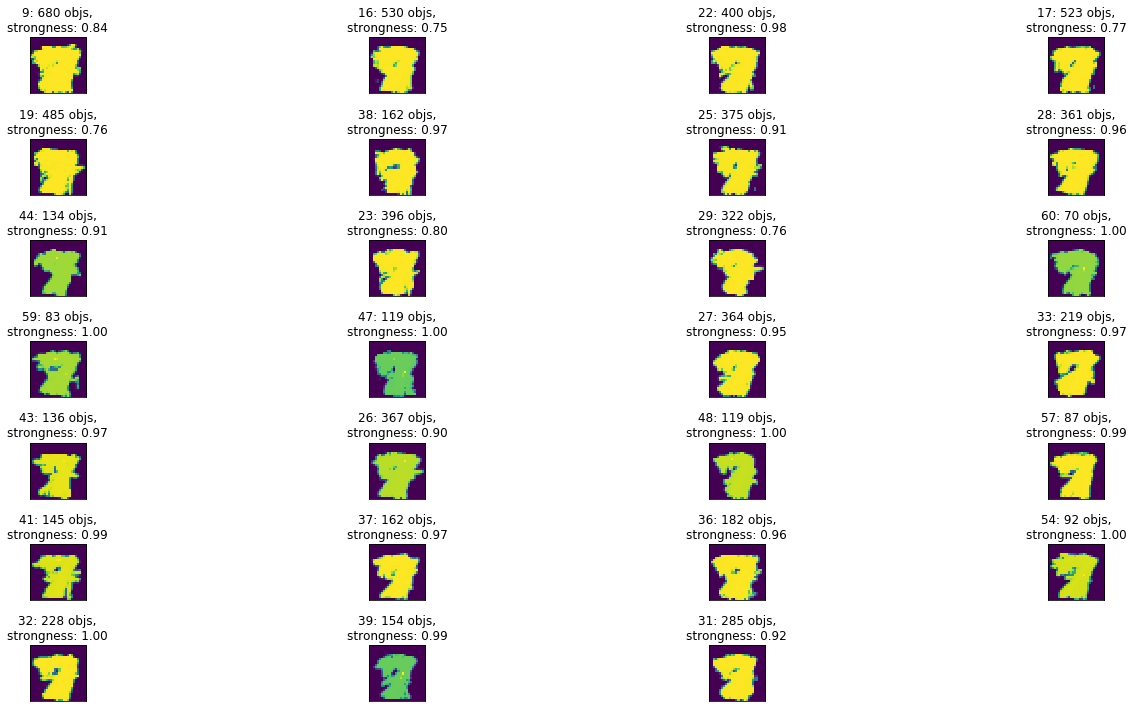

In [1084]:
plt.figure(figsize=(20,10))
for idx, c in enumerate(sc):
    plt.subplot(7,4,idx+1)
    str_ = f"{c.get_id()}: {len(c.get_extent())} objs,\nstrongness: {c._metrics['strongness']:.2f}"
    #ext_full = mvcntx_full.get_extent(c.get_intent())
    int_ = c.get_intent()
    img = get_intent_image(int_, ds.columns)
    #img = ds.loc[ext_full].mean(0).values.reshape((img_rows, img_cols))
    #plt.pcolormesh(img, )
    plt.imshow(img)
    #sns.heatmap(img)
    plt.title(str_)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    #print(str_)
plt.subplots_adjust()
plt.tight_layout()
plt.show()

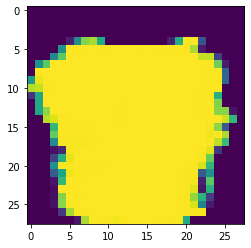

In [1057]:
plt.imshow(get_intent_image(mvcntx.get_intent(list(ds[flg].index)), ds.columns))

In [837]:
ext_0 = mvcntx_full.get_extent(sc[0].get_intent())
ext_1 = mvcntx_full.get_extent(sc[1].get_intent())

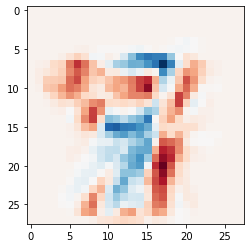

In [846]:
plt.imshow((ds.loc[ext_0].mean()-ds.loc[ext_1].mean()).values.reshape((28,28)), cmap='RdBu')

# Интерпретируем понятия с ошибками

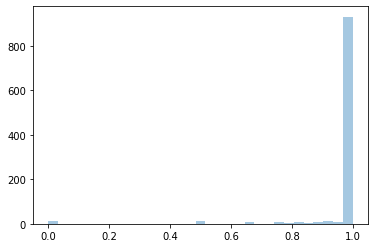

In [862]:
sns.distplot([c._metrics['accuracy'] for c in fm.get_concepts()], kde=False)

In [864]:
def get_mean_image(ds, ext_):
    return ds.loc[ext_].mean().values.reshape((img_rows, img_cols))

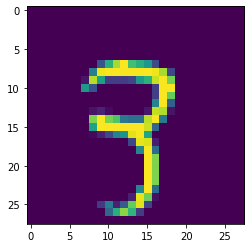

In [866]:
plt.imshow(get_mean_image(ds, ['1062']))

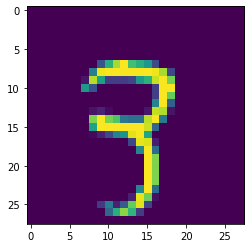

In [1086]:
plt.imshow(get_intent_image(mvcntx.get_intent(['1062']), ds.columns))

In [1087]:
error_cncpts = [c for c in fm.get_concepts() if c._metrics['accuracy']<0.7 and c._metrics['strongness']>0.9]
len(error_cncpts), len(calc_cover_of_concepts(error_cncpts))

(35, 51)

In [1088]:
min_error_cncpts = get_min_concepts(error_cncpts)
len(min_error_cncpts)

26

In [1091]:
fm.get_concept_by_id(324)._metrics

{'strongness': 1.0,
 'stab_min_bound': 0.875,
 'stab_max_bound': 0.875,
 'log_stab_min_bound': 3.0,
 'log_stab_max_bound': 3.0,
 'lstab_min_bound': -781.0,
 'n_uncovered': 0,
 'perc_of_class_0': 0.0,
 'perc_of_class_1': 0.0,
 'perc_of_class_2': 0.0,
 'perc_of_class_3': 0.3333333333333333,
 'perc_of_class_4': 0.0,
 'perc_of_class_5': 0.0,
 'perc_of_class_6': 0.0,
 'perc_of_class_7': 0.6666666666666666,
 'perc_of_class_8': 0.0,
 'perc_of_class_9': 0.0,
 'accuracy': 0.6666666666666666}

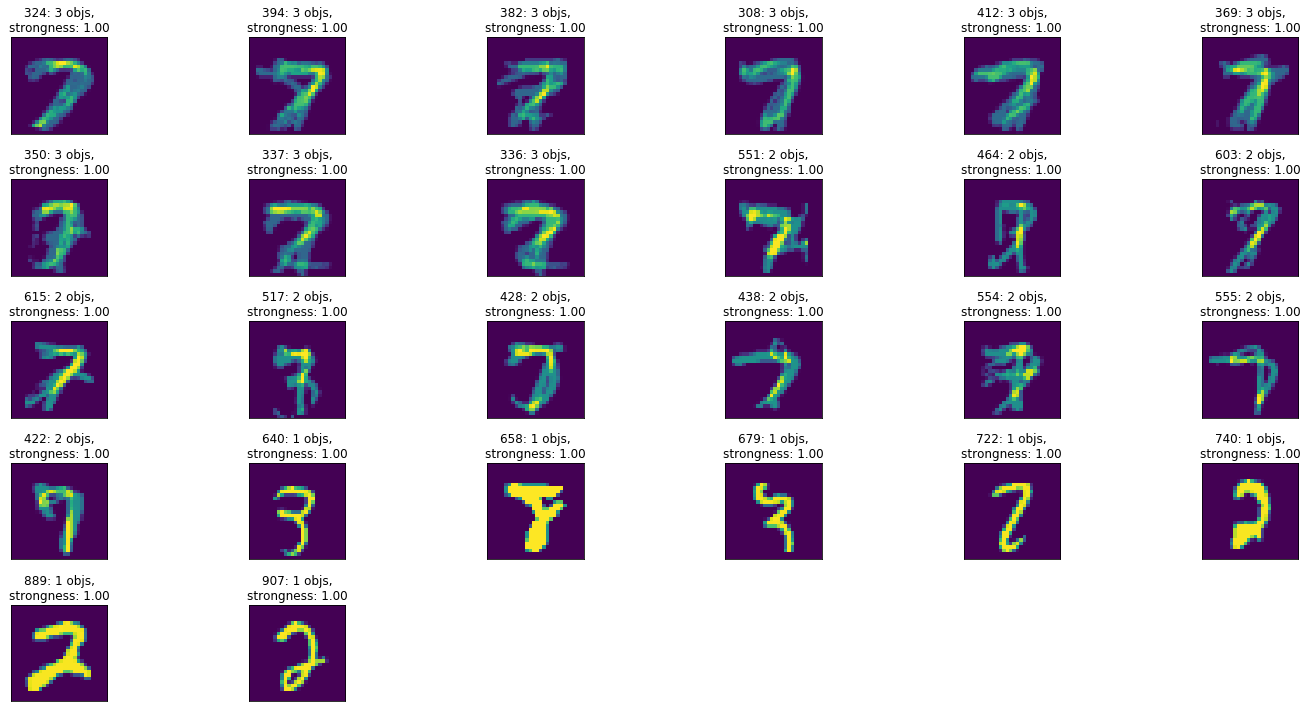

In [1089]:
plt.figure(figsize=(20,10))
for idx, c in enumerate(min_error_cncpts):
    plt.subplot(5,6,idx+1)
    str_ = f"{c.get_id()}: {len(c.get_extent())} objs,\nstrongness: {c._metrics['strongness']:.2f}"
    ext_full = mvcntx_full.get_extent(c.get_intent())
    img = ds.loc[ext_full].mean(0).values.reshape((img_rows, img_cols))
    #plt.pcolormesh(img, )
    plt.imshow(img)
    #sns.heatmap(img)
    plt.title(str_)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    #print(str_)
plt.subplots_adjust()
plt.tight_layout()
plt.show()

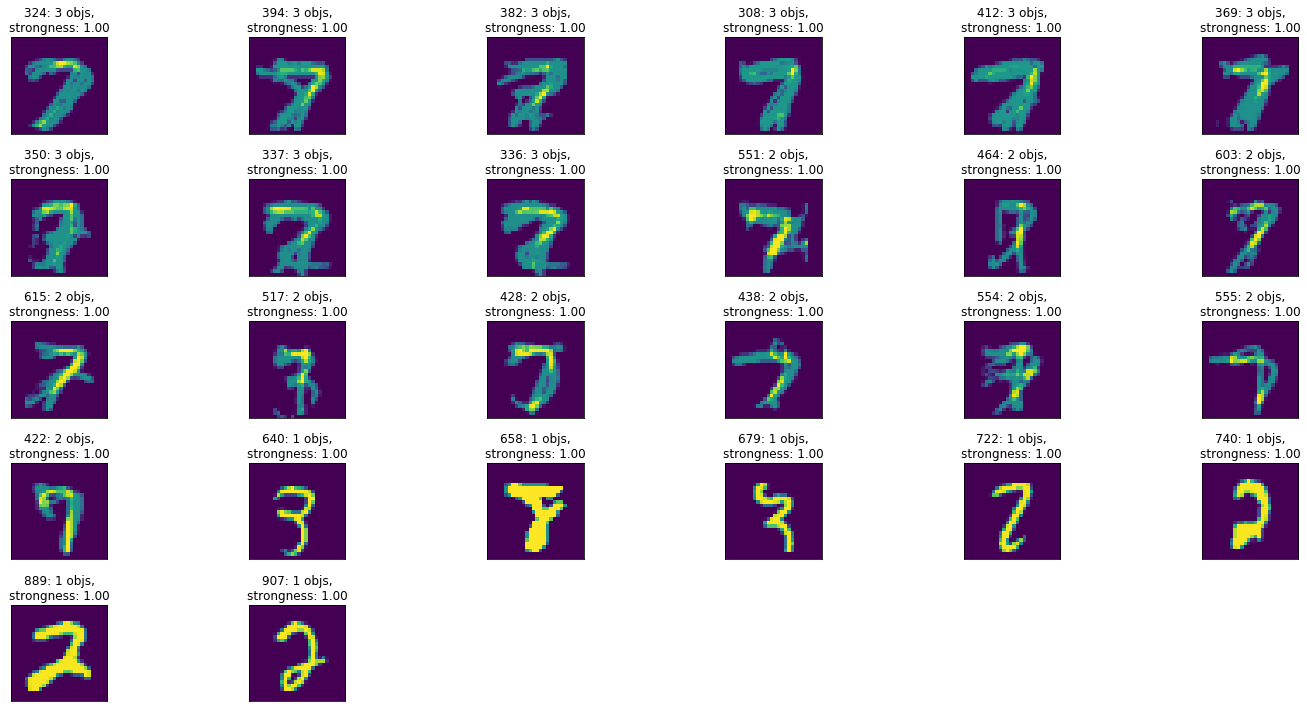

In [1092]:
plt.figure(figsize=(20,10))
for idx, c in enumerate(min_error_cncpts):
    plt.subplot(5,6,idx+1)
    str_ = f"{c.get_id()}: {len(c.get_extent())} objs,\nstrongness: {c._metrics['strongness']:.2f}"
    #ext_full = mvcntx_full.get_extent(c.get_intent())
    int_ = c.get_intent()
    img = get_intent_image(int_, ds.columns)
    #img = ds.loc[ext_full].mean(0).values.reshape((img_rows, img_cols))
    #plt.pcolormesh(img, )
    plt.imshow(img)
    #sns.heatmap(img)
    plt.title(str_)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    #print(str_)
plt.subplots_adjust()
plt.tight_layout()
plt.show()

In [1095]:
ds.loc[fm.get_concept_by_id(324).get_extent()]

,"(0,0)","(0,1)","(0,2)","(0,3)","(0,4)","(0,5)","(0,6)","(0,7)","(0,8)","(0,9)",...,"(27,18)","(27,19)","(27,20)","(27,21)","(27,22)","(27,23)","(27,24)","(27,25)","(27,26)","(27,27)"
1681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
get_mean_image(ds, ['1681'])

In [964]:
error_cncpts = [c for c in fm_stab.get_concepts() if c._metrics.get('perc_of_class_2',0)>0.1 and c._metrics['strongness']>0]
len(error_cncpts), len(calc_cover_of_concepts(error_cncpts))

(0, 0)

In [919]:
min_error_cncpts = get_min_concepts(error_cncpts)
len(min_error_cncpts)

8

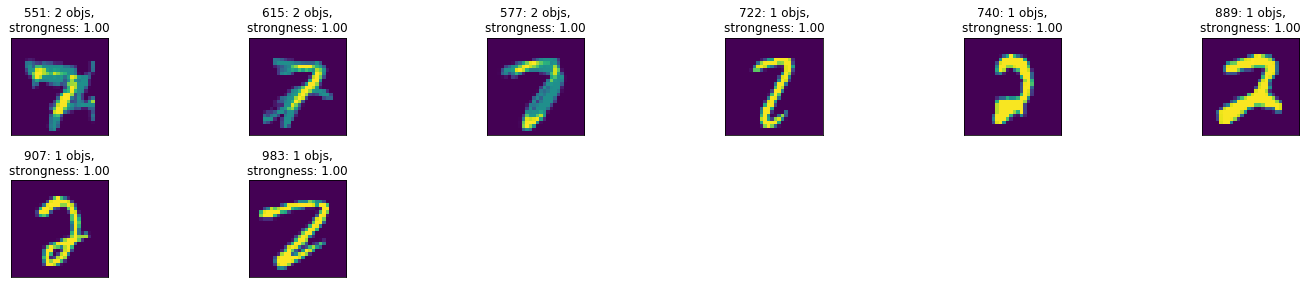

In [920]:
plt.figure(figsize=(20,10))
for idx, c in enumerate(min_error_cncpts):
    plt.subplot(5,6,idx+1)
    str_ = f"{c.get_id()}: {len(c.get_extent())} objs,\nstrongness: {c._metrics['strongness']:.2f}"
    ext_full = mvcntx_full.get_extent(c.get_intent())
    img = ds.loc[ext_full].mean(0).values.reshape((img_rows, img_cols))
    #plt.pcolormesh(img, )
    plt.imshow(img)
    #sns.heatmap(img)
    plt.title(str_)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    #print(str_)
plt.subplots_adjust()
plt.tight_layout()
plt.show()